In [1]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import kagglehub

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

file_path = os.path.join(path, "healthcare-dataset-stroke-data.csv")
df = pd.read_csv(file_path)

In [2]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 1. Análise Exploratória de dados (EDA)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### Overview geral do dataset (formato, colunas, tipos de dados e estatísticas iniciais)

In [4]:
print(f"\nDataset Shape: {df.shape}") 


Dataset Shape: (5110, 12)


In [5]:
print(f"\nData Types:")
print(df.dtypes)


Data Types:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [6]:
print(f"\nBasic Statistics:")
print(df.describe())


Basic Statistics:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000

### Análise dos valores faltantes e/ou inválidos

In [7]:
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
})
print(missing_df)

               Column  Missing_Count  Missing_Percentage
0                  id              0            0.000000
1              gender              0            0.000000
2                 age              0            0.000000
3        hypertension              0            0.000000
4       heart_disease              0            0.000000
5        ever_married              0            0.000000
6           work_type              0            0.000000
7      Residence_type              0            0.000000
8   avg_glucose_level              0            0.000000
9                 bmi            201            3.933464
10     smoking_status              0            0.000000
11             stroke              0            0.000000


### Distribuição das variáveis-alvo

##### Distribuição de pessoas que já tiveram AVC:

In [8]:
stroke_counts = df['stroke'].value_counts()
stroke_percent = (df['stroke'].value_counts() / len(df)) * 100
print(f"\nStroke Distribution:")
print(f"  No Stroke (0): {stroke_counts[0]} ({stroke_percent[0]:.2f}%)")
print(f"  Stroke (1):    {stroke_counts[1]} ({stroke_percent[1]:.2f}%)")


Stroke Distribution:
  No Stroke (0): 4861 (95.13%)
  Stroke (1):    249 (4.87%)


### Análise das features numéricas

Não é necessário analisar a feature de id, mesmo sendo uma coluna numérica do dataset.

In [10]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in 'stroke id']
print(f"\nNumerical Features: {numerical_cols}")

print("\nNumerical Features Statistics:")
print(df[numerical_cols].describe())


Numerical Features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

Numerical Features Statistics:
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi  
count  4909.000000  
mean     28.893237  
std       7.854067  
min      10.300000  
25%      23.500000  
50%      28.100000  
75%      33.100000  
max      97.600000  


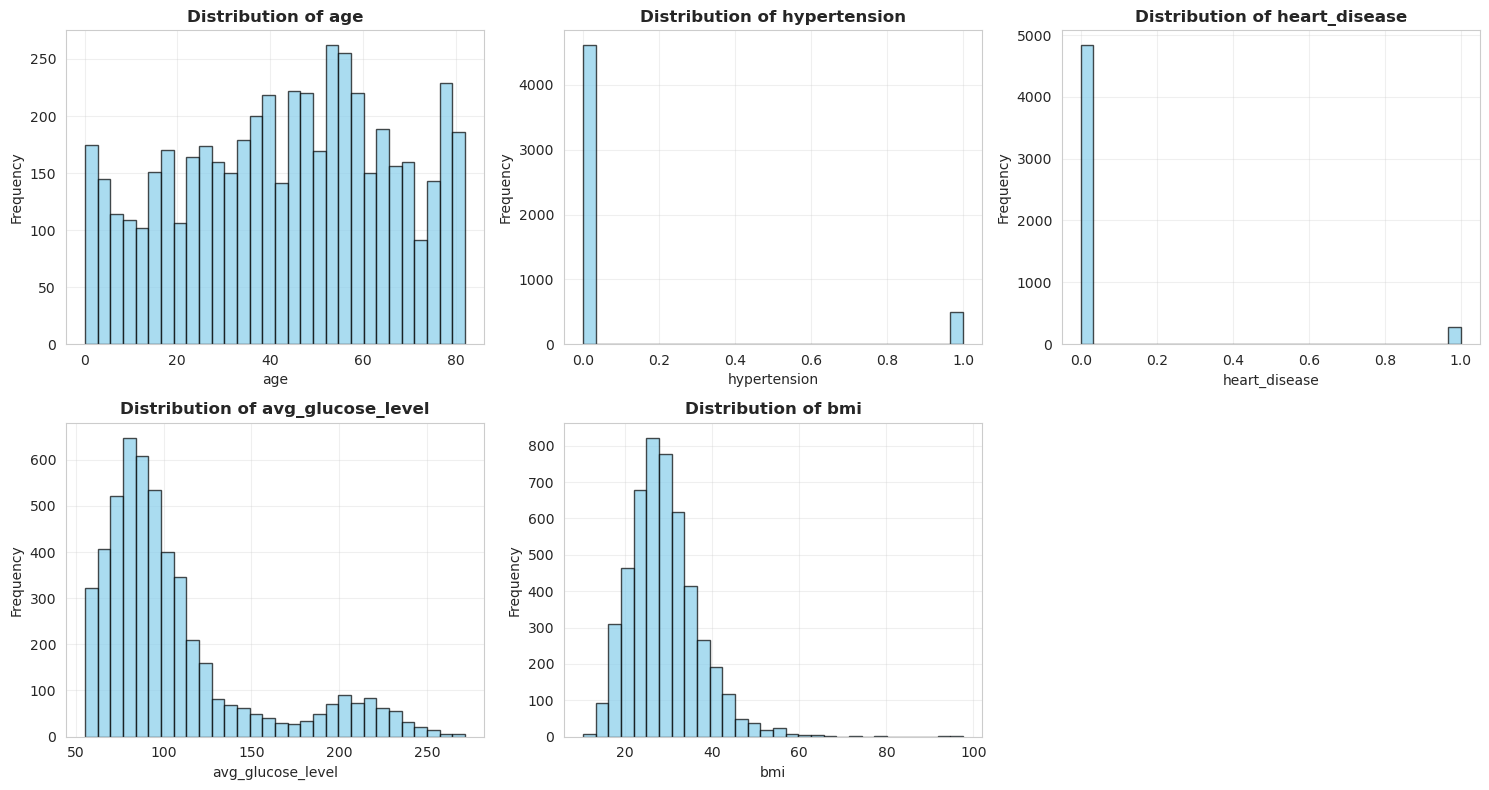

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

Obs: heart_disease e hypertension são variáveis binárias

### Análise das features categóricas

In [15]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical Features: {categorical_cols}")

for col in categorical_cols:
    print(f"\n{col} - Value Counts:")
    print(df[col].value_counts())


Categorical Features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

gender - Value Counts:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

ever_married - Value Counts:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

work_type - Value Counts:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Residence_type - Value Counts:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

smoking_status - Value Counts:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


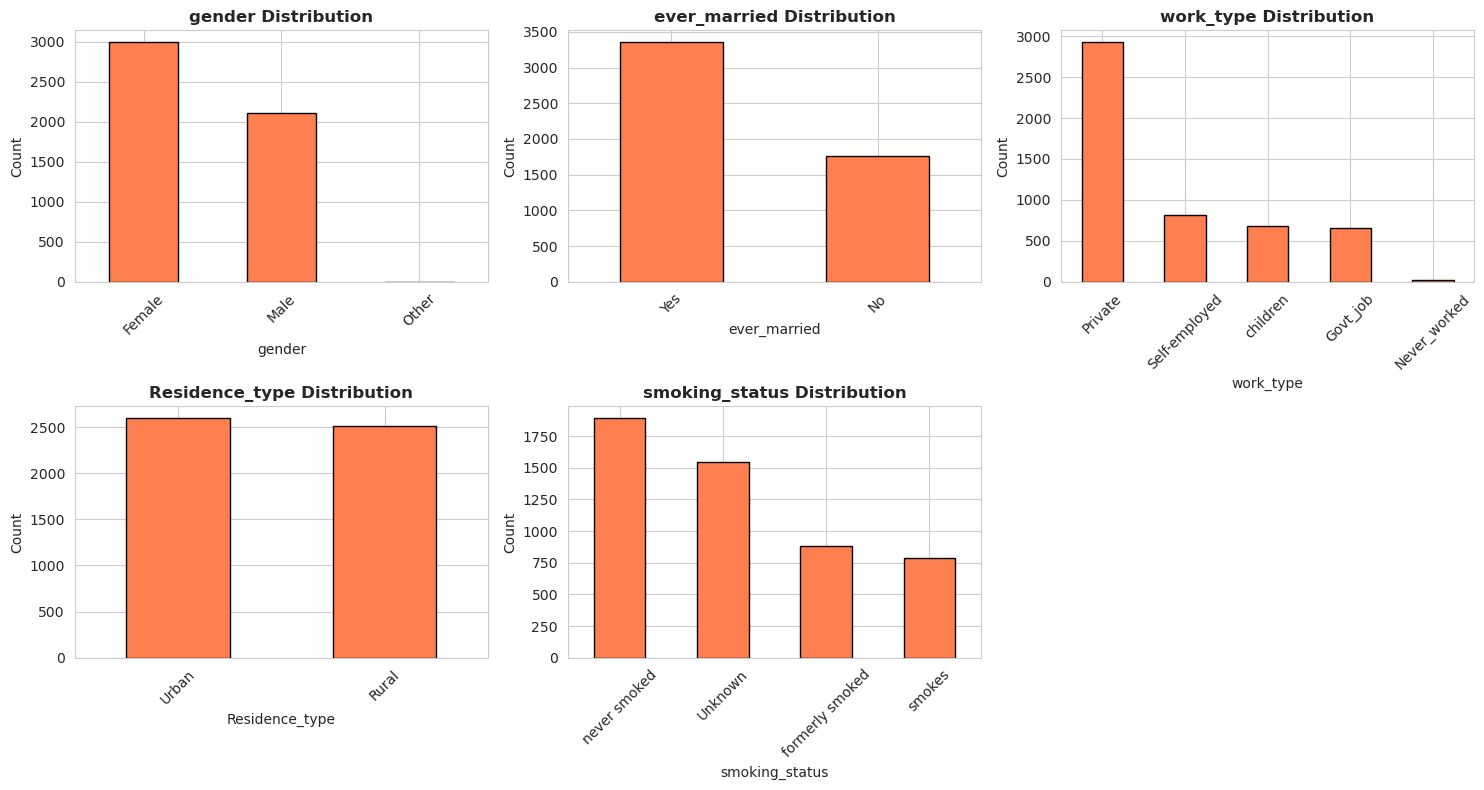

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Análise da correlação entre as features


Correlation with Stroke (Target Variable):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
ever_married         0.108340
bmi                  0.042374
smoking_status       0.028123
Residence_type       0.015458
gender               0.008929
id                   0.006388
work_type           -0.032316
Name: stroke, dtype: float64


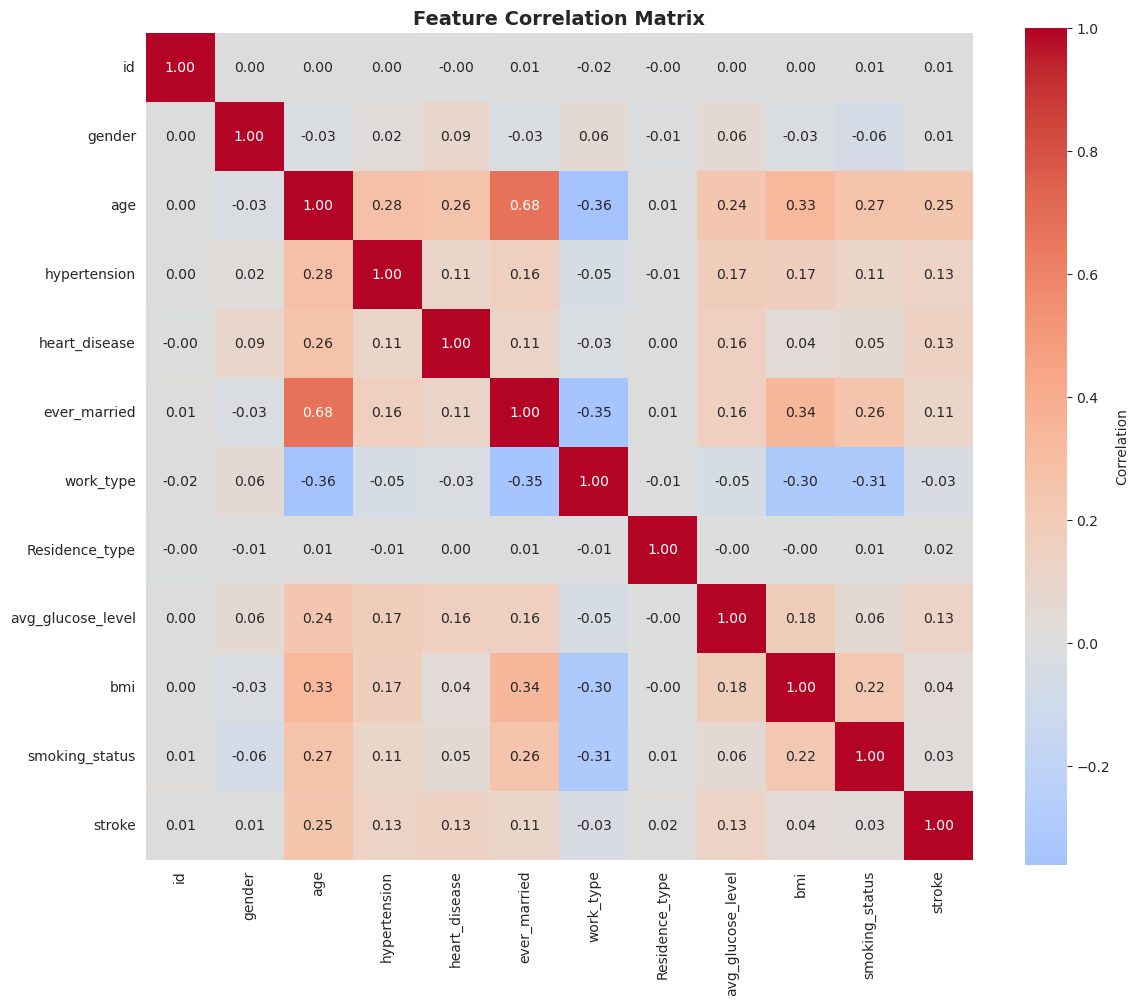

In [31]:
df_corr = df.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col])
    label_encoders[col] = le

correlation_matrix = df_corr.corr()

stroke_corr = correlation_matrix['stroke'].sort_values(ascending=False)
print("\nCorrelation with Stroke (Target Variable):")
print(stroke_corr)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()